# SETUP

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from models.LigandModel import CHEMFEATURE

## Loading

### Model loading

In [2]:
# No need to run this cell and run the model, the embeddings are loaded after
#device = 'cuda'
#model = CHEMFEATURE(device)

### Data Loading

In [74]:
# Load full dataset
best_ligands_df = pd.read_csv('../data/best_ligands_old.csv') # dataframe with best ligand for each selected protein

# Filter the unique smiles while keeping the index for later use
unique_smiles_df = pd.DataFrame({'Ligand SMILES': best_ligands_df['Ligand SMILES'].unique()})
unique_smiles_df['index'] = unique_smiles_df['Ligand SMILES'].apply(lambda x: best_ligands_df.index[best_ligands_df['Ligand SMILES'] == x].tolist())
unique_smiles_df['Ligand SMILES'] = unique_smiles_df['Ligand SMILES'].apply(lambda x: x[:512]) # the model can only take max 512 letters long smiles. Truncation.

Dataframes:
- best_ligand_df: SMILES of Best ligand to protein.
- unique_smiles_df: unique SMILES (truncated if above 512) and index in the original df --> input of the embedder

# MODEL

## Ligand embedding creation

In [75]:
run = False # No need to run, just load the embeddings that I computed on Colab
if run:
    embeddings = model.get_representations(unique_smiles_df['Ligand SMILES'])
else:
    embeddings = np.load('../data/embeddings_array_old.npy')


## DIMENSIONALITY REDUCTION

### PCA

In [76]:
# Normalize the features
X_normalized = StandardScaler().fit_transform(embeddings)

# Apply the PCA
n = 3
pca = PCA(n_components=n)
X_transformed_PCA = pca.fit_transform(X_normalized)

# Create dataframe for PCA values
pca_df = pd.DataFrame(X_transformed_PCA, columns=[f'PC {i}' for i in range(1,n+1)])

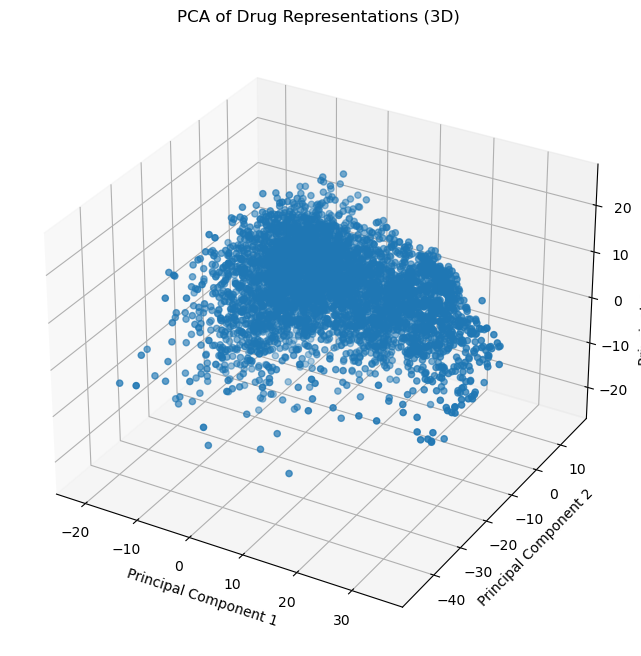

In [77]:
# Plot 3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC 1'], pca_df['PC 2'], pca_df['PC 3'])
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA of Drug Representations (3D)')
plt.show()

We cannot see anything in this space that may be relevant. Maybe we can try t-SNE or umap

### UMAP

In [78]:
import umap

# Normalize the features
X_normalized = StandardScaler().fit_transform(embeddings)

# Apply UMAP
n = 3
umap_model = umap.UMAP(n_components=n)
X_transformed_UMAP = umap_model.fit_transform(X_normalized)

# Create dataframe for UMAP values
umap_df = pd.DataFrame(X_transformed_UMAP, columns=[f'UMAP {i}' for i in range(1, n+1)])

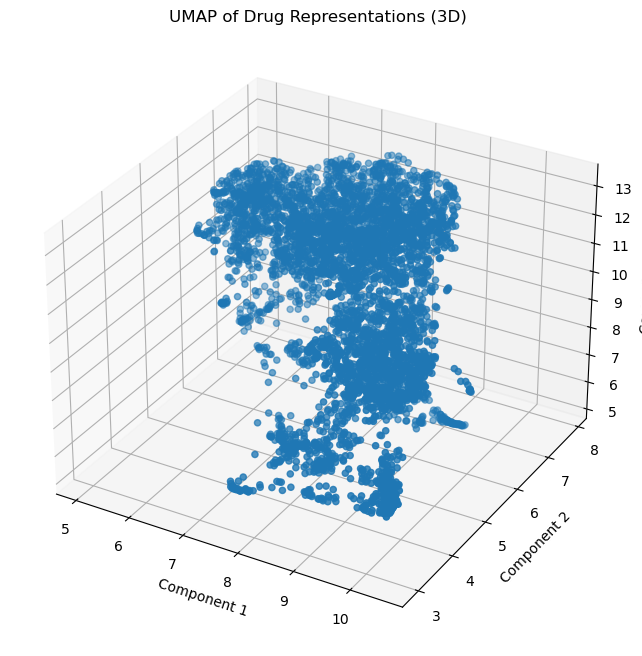

In [79]:
# Plot 3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap_df['UMAP 1'], umap_df['UMAP 2'], umap_df['UMAP 3'])
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('UMAP of Drug Representations (3D)')
plt.show()

In [80]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Normalize the features
X_normalized = StandardScaler().fit_transform(embeddings)

# Apply t-SNE
n = 3
tsne = TSNE(n_components=n, random_state=42)
X_transformed_TSNE = tsne.fit_transform(X_normalized)

# Create dataframe for t-SNE values
tsne_df = pd.DataFrame(X_transformed_TSNE, columns=[f't-SNE {i}' for i in range(1, n+1)])

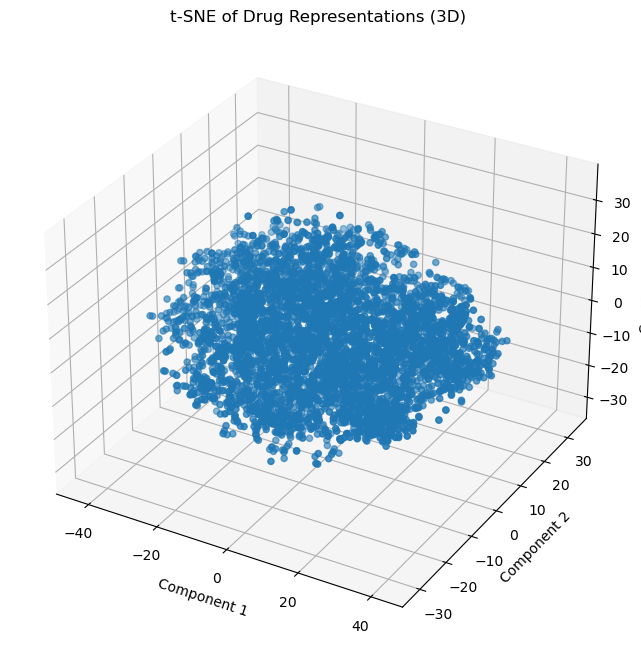

In [81]:
#  Plot 3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_df['t-SNE 1'], tsne_df['t-SNE 2'], tsne_df['t-SNE 3'])
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('t-SNE of Drug Representations (3D)')
plt.show()

## CLUSTERING

### K-MEANS

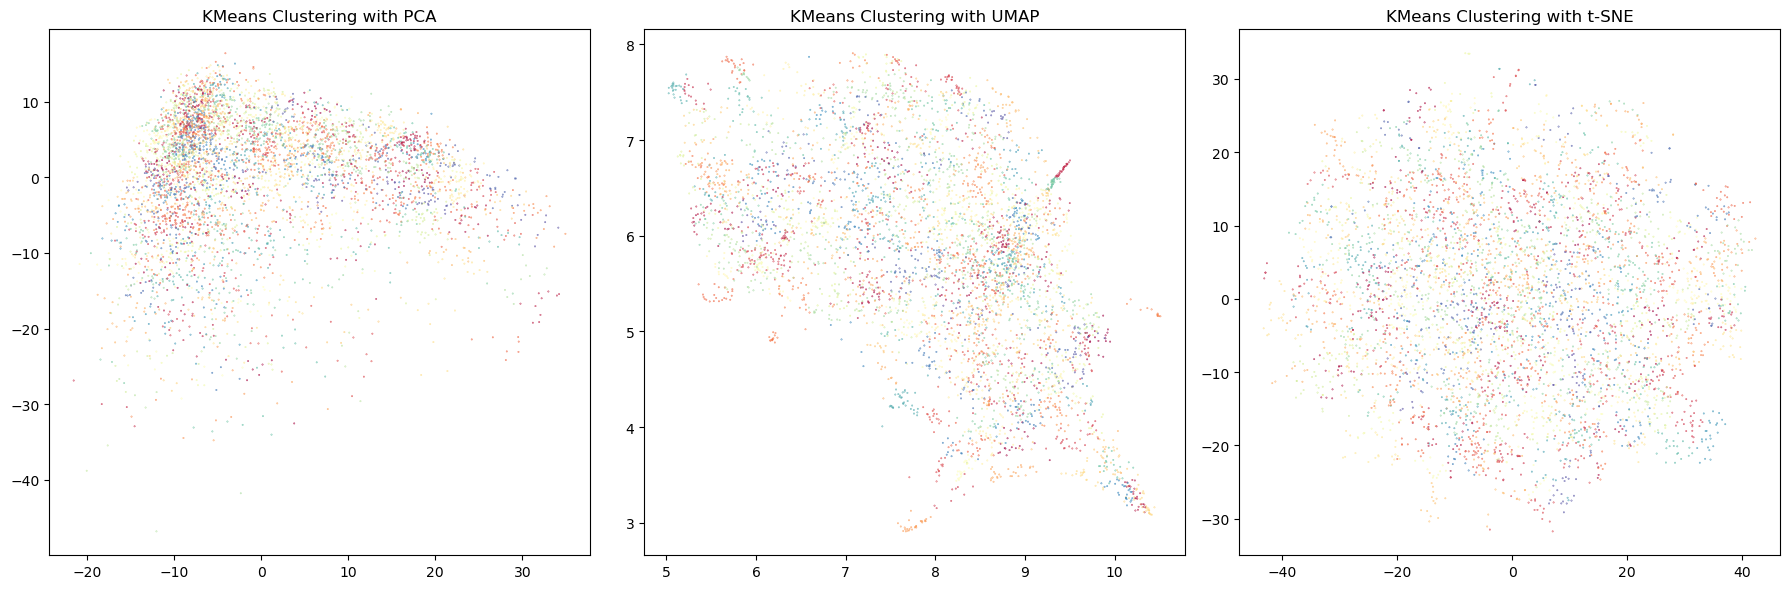

In [82]:
from sklearn.cluster import KMeans

# Perform KMeans clustering
kmeans_labels_PCA = KMeans(n_clusters=300, random_state=42).fit_predict(X_transformed_PCA)
kmeans_labels_UMAP = KMeans(n_clusters=300, random_state=42).fit_predict(X_transformed_UMAP)
kmeans_labels_TSNE = KMeans(n_clusters=300, random_state=42).fit_predict(X_transformed_TSNE)


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot PCA results
scatter1 = axs[0].scatter(X_transformed_PCA[:, 0], X_transformed_PCA[:, 1], c=kmeans_labels_PCA, s=0.1, cmap='Spectral')
axs[0].set_title('KMeans Clustering with PCA')

# Plot UMAP results
scatter2 = axs[1].scatter(X_transformed_UMAP[:, 0], X_transformed_UMAP[:, 1], c=kmeans_labels_UMAP, s=0.1, cmap='Spectral')
axs[1].set_title('KMeans Clustering with UMAP')

# Plot t-SNE results
scatter3 = axs[2].scatter(X_transformed_TSNE[:, 0], X_transformed_TSNE[:, 1], c=kmeans_labels_TSNE, s=0.1, cmap='Spectral')
axs[2].set_title('KMeans Clustering with t-SNE')

# Show plots
plt.tight_layout()
plt.show()

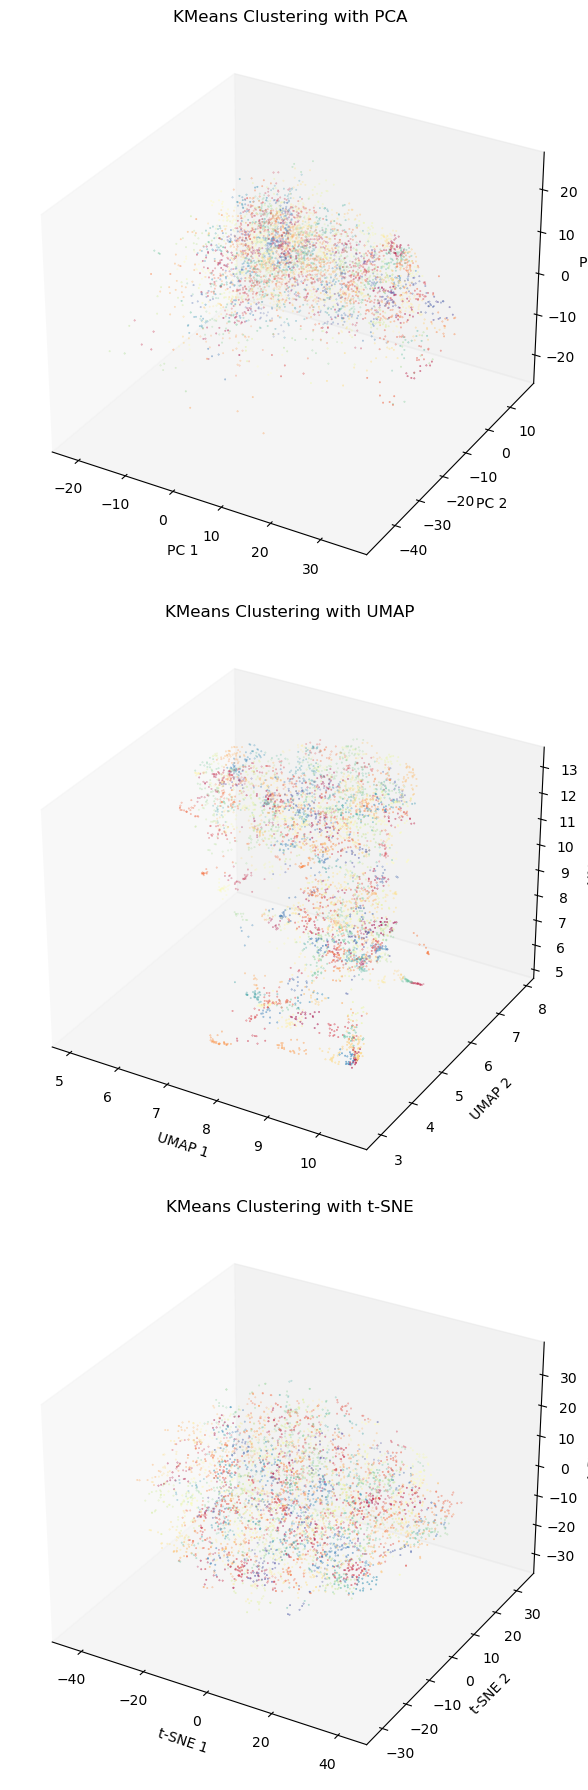

In [83]:
# Create subplots
fig = plt.figure(figsize=(6, 18))

# Plot PCA results in 3D
ax1 = fig.add_subplot(311, projection='3d')
scatter1 = ax1.scatter(X_transformed_PCA[:, 0], X_transformed_PCA[:, 1], X_transformed_PCA[:, 2], c=kmeans_labels_PCA, s=0.1, cmap='Spectral')
ax1.set_title('KMeans Clustering with PCA')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
ax1.set_zlabel('PC 3')
ax1.grid(False)
ax1.set_facecolor('white')

# Plot UMAP results in 3D
ax2 = fig.add_subplot(312, projection='3d')
scatter2 = ax2.scatter(X_transformed_UMAP[:, 0], X_transformed_UMAP[:, 1], X_transformed_UMAP[:, 2], c=kmeans_labels_UMAP, s=0.1, cmap='Spectral')
ax2.set_title('KMeans Clustering with UMAP')
ax2.set_xlabel('UMAP 1')
ax2.set_ylabel('UMAP 2')
ax2.set_zlabel('UMAP 3')
ax2.grid(False)
ax2.set_facecolor('white')

# Plot t-SNE results in 3D
ax3 = fig.add_subplot(313, projection='3d')
scatter3 = ax3.scatter(X_transformed_TSNE[:, 0], X_transformed_TSNE[:, 1], X_transformed_TSNE[:, 2], c=kmeans_labels_TSNE, s=0.1, cmap='Spectral')
ax3.set_title('KMeans Clustering with t-SNE')
ax3.set_xlabel('t-SNE 1')
ax3.set_ylabel('t-SNE 2')
ax3.set_zlabel('t-SNE 3')
ax3.grid(False)
('white')


# Show plots
plt.tight_layout()
plt.show()

### HDBSCAN
https://umap-learn.readthedocs.io/en/latest/clustering.html
Widely used for UMAP.

I don't think we need it here.

In [ ]:
import hdbscan
hdbscan_labels_UMAP = hdbscan.HDBSCAN(
    min_samples=2,
    min_cluster_size = 10,
    max_cluster_size=30,
    allow_single_cluster = True
).fit_predict(X_transformed_UMAP)

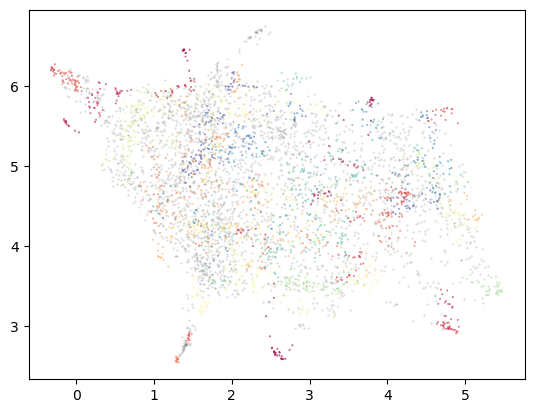

In [ ]:
clustered = (hdbscan_labels_UMAP >= 0)
plt.scatter(X_transformed_UMAP[~clustered, 0],
            X_transformed_UMAP[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(X_transformed_UMAP[clustered, 0],
            X_transformed_UMAP[clustered, 1],
            c=hdbscan_labels_UMAP[clustered],
            s=0.1,
            cmap='Spectral')

# Final merge

In [ ]:
# Reset the index of unique_smiles_df
unique_smiles_df = unique_smiles_df.reset_index(drop=True)

# Concatenate the DataFrames
merged_umap_df = pd.concat([unique_smiles_df, X_transformed_UMAP], axis=1)

Now, 'merged_umap_df' contains 'smile', 'index', and the UMAP components.

Next step: put the corresponding labels of each ligand back to the protein